In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os

In [26]:
p = cv2.imread('patch.jpg', cv2.IMREAD_GRAYSCALE)

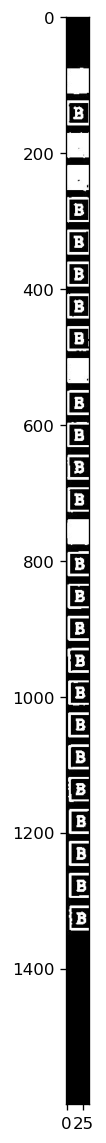

In [29]:
plt.figure(figsize=(10,12))
plt.imshow(p, cmap='gray')

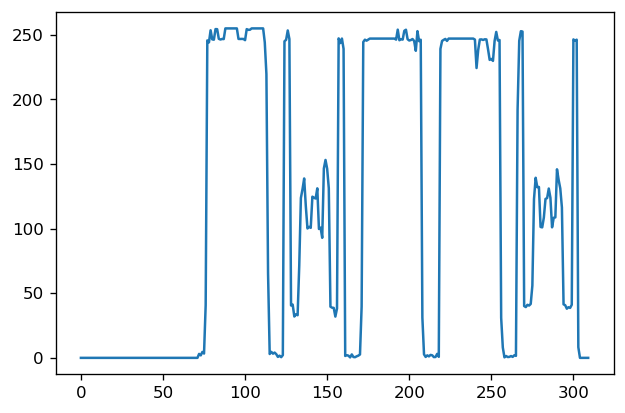

In [335]:
data = np.sum(p, axis=1)/p.shape[1]
# plt.plot(np.arange(200), np.sum(p[:200,:], axis=1))
plt.plot(np.arange(len(data[:310])), data[:310])

In [385]:
data2 = data

In [318]:
kernel = np.array([7,26,41,26, 7])
kernel = kernel / np.sum(kernel)
np.convolve(data2, kernel, mode='valid').shape

(296,)

In [386]:
data2_smoothed = data2# np.convolve(data2, kernel, mode='same')

In [316]:
sobel = np.array([1,0,-1])

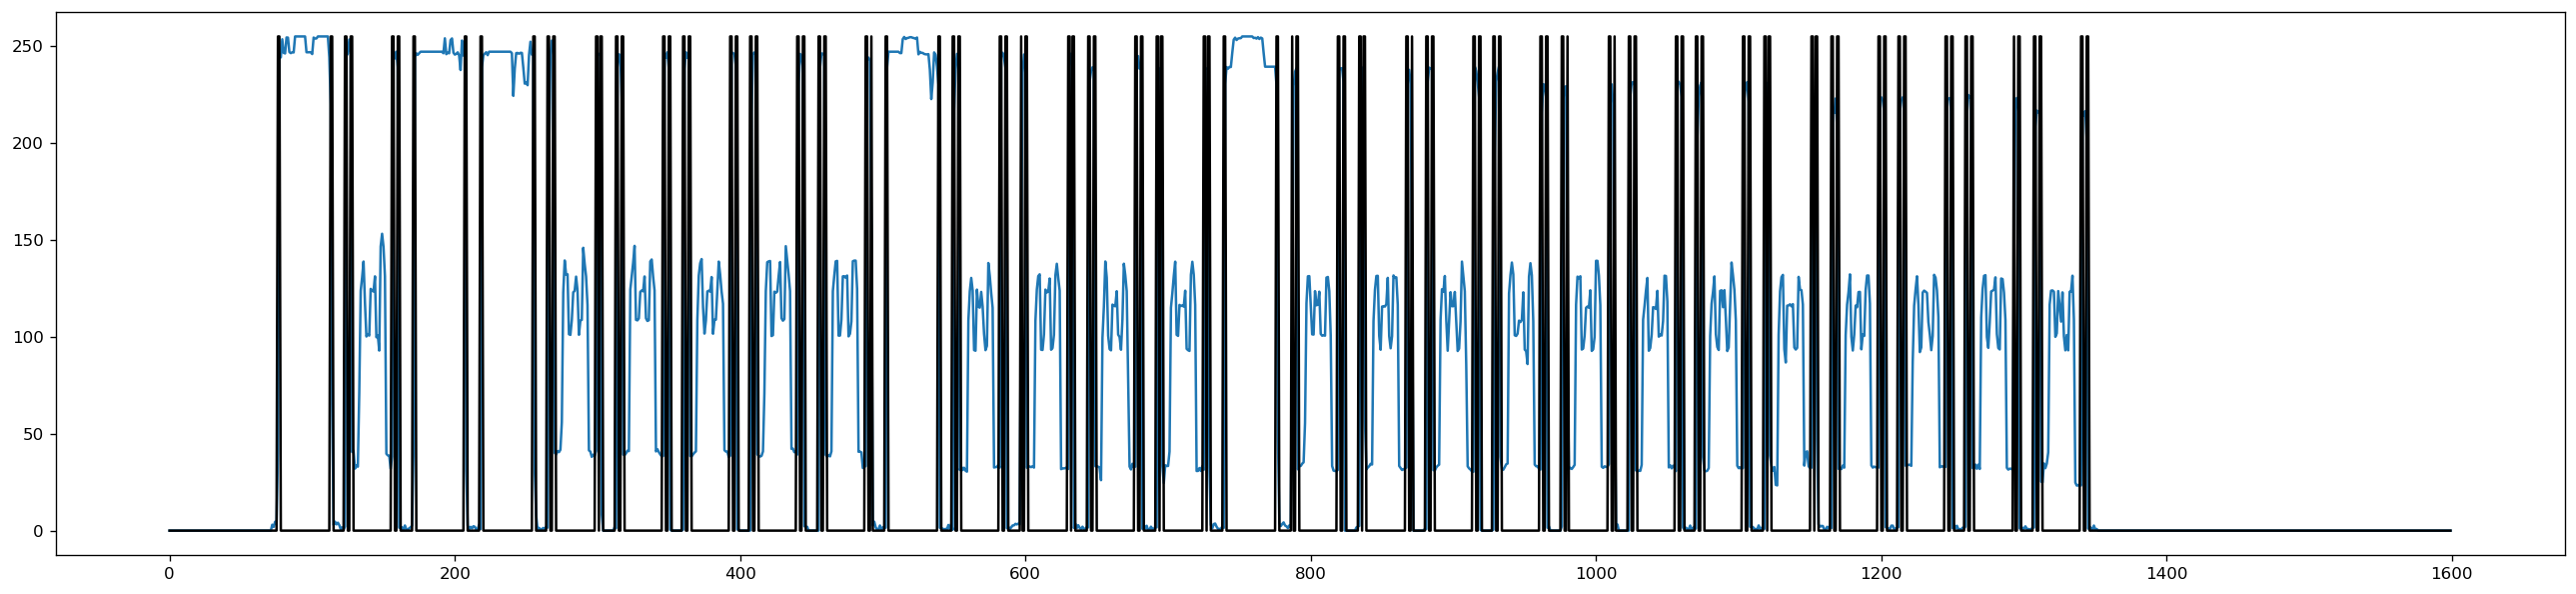

In [387]:
plt.figure(figsize=(n_clusters,6))
# plt.plot(np.arange(len(data2)-2), np.convolve(data2_smoothed, sobel, mode='same'))
plt.plot(np.arange(len(data2)), data2_smoothed)
# plt.plot((0, 300),(100, 100), color='green')
# plt.plot((0, 300),(-100, -100), color='green')
derivative = np.where(np.abs(np.convolve(data2_smoothed, sobel, mode='same'))>150, 255, 0)
plt.plot(np.arange(len(data2)), derivative, color='black')

In [388]:
mask = np.array([True, True])
out = np.zeros(len(derivative)-len(mask)+1)
for i in range(len(derivative)-len(mask)+1):
    out[i] = np.all(derivative[i:i+len(mask)].astype(np.bool8) & mask)
out = np.hstack((out, 0))

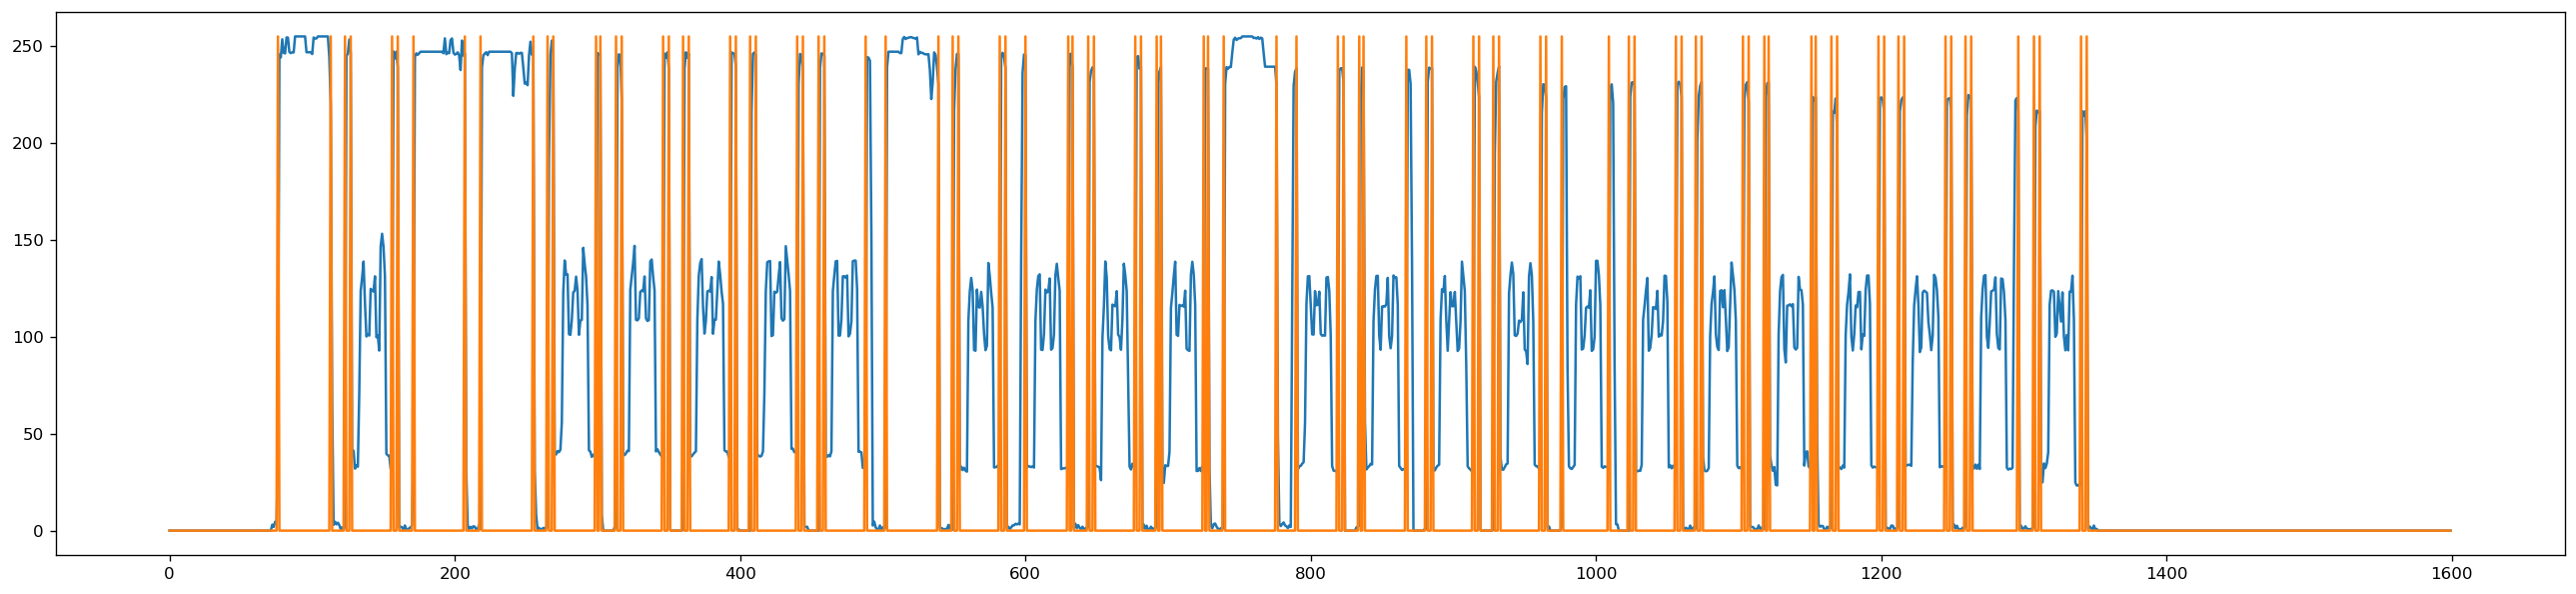

In [389]:
plt.figure(figsize=(n_clusters,6))
plt.plot(np.arange(len(data2)), data2_smoothed)
plt.plot(np.arange(len(out)), 255*out)

In [390]:
p.shape

(1600, 33)

In [391]:
out.shape

(1600,)

In [393]:
np.where(out)

(array([  76,  113,  123,  127,  156,  160,  171,  207,  218,  255,  265,
         269,  299,  302,  313,  317,  346,  350,  360,  364,  393,  397,
         407,  411,  440,  444,  455,  459,  488,  502,  539,  549,  553,
         582,  586,  600,  630,  633,  644,  648,  677,  681,  692,  695,
         725,  728,  739,  776,  790,  819,  823,  834,  837,  867,  881,
         885,  914,  918,  928,  932,  961,  965,  976, 1009, 1023, 1027,
        1056, 1060, 1070, 1074, 1103, 1107, 1118, 1121, 1151, 1154, 1165,
        1169, 1198, 1202, 1212, 1216, 1245, 1249, 1259, 1263, 1296, 1307,
        1311, 1340, 1344]),)

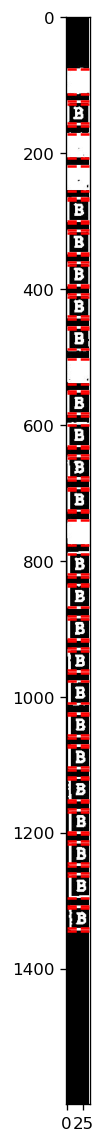

In [394]:
plt.figure(figsize=(10,12))
plt.imshow(p, cmap='gray')
for i in np.where(out):
    plt.plot((0,33),(i,i), 'r--')

In [195]:
data_trim = np.hstack((0,np.trim_zeros(data),0))

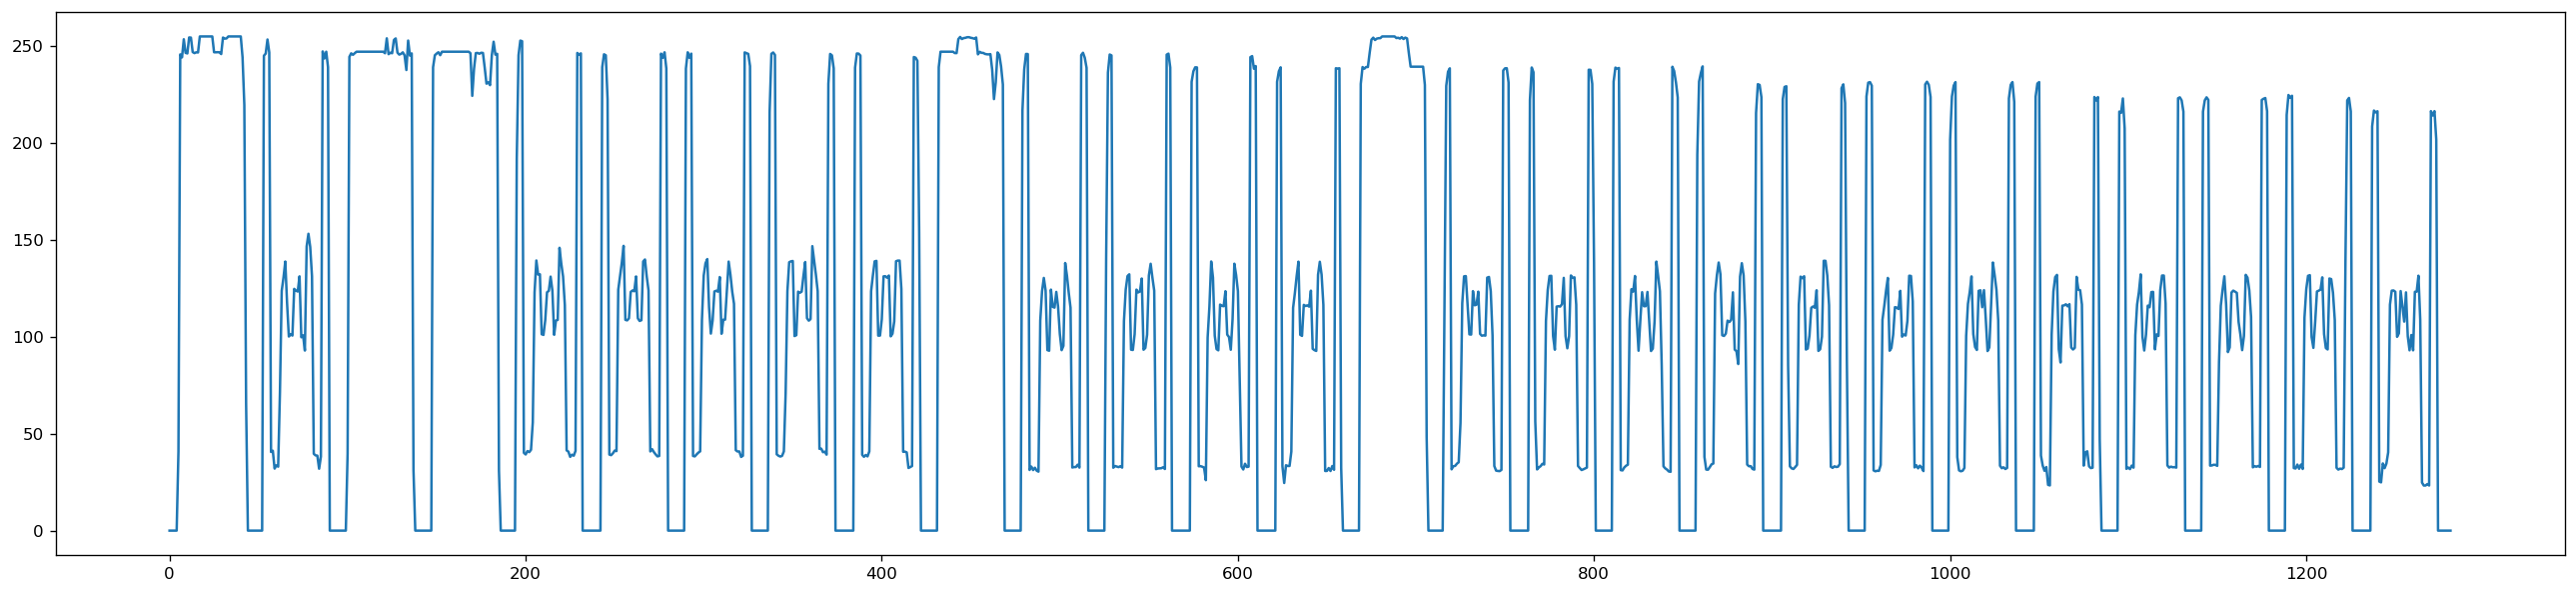

In [395]:
plt.figure(figsize=(n_clusters,6))
data_thresh = data_trim.copy()
data_thresh[data_thresh<20] = 0
plt.plot(np.arange(len(data_thresh)), data_thresh)

In [410]:
def connected_components(data):
    labels = np.zeros_like(data).astype(np.uint64)
    n = 0
    for i in range(len(data[1:])):
        left = data[i-1]
        if data[i] != 0:
            if left == 0:
                n += 1
                labels[i] = n
            else:
                labels[i] = n
            
    return labels

cc = connected_components(data_thresh)

In [436]:
unique_labels = np.unique(cc)
color_map = {l:np.random.choice(range(256), size=3).astype(np.float64)/255 for l in unique_labels} #assign random color to each label
color_map[0] = np.array([0, 0, 0])/255

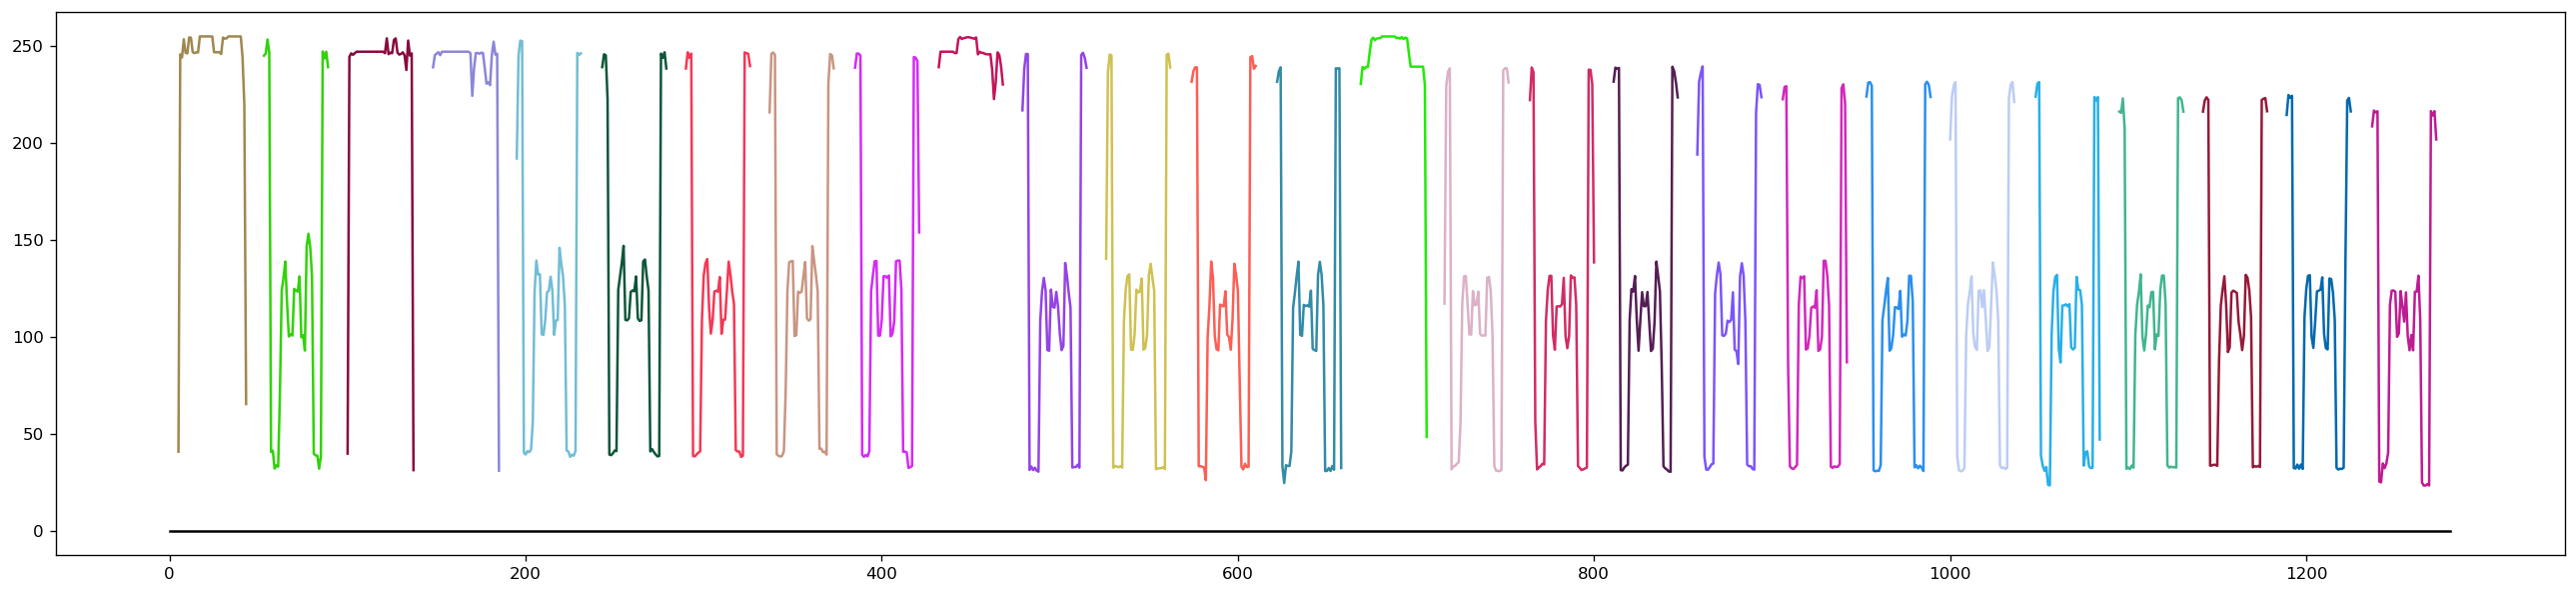

In [440]:
plt.figure(figsize=(n_clusters,6))
# plt.plot(np.arange(len(data_thresh)), data_thresh, color='black')
for c in np.unique(cc):
    plt.plot(np.where(cc==c)[0], data_thresh[cc==c], color=color_map[c])

In [277]:
n_clusters = 27
centers = np.sort(np.random.randint(low=0, high=len(data_thresh), size=n_clusters)).astype(np.float64)
# centers = np.linspace(0, len(data_thresh), n_clusters+2)[1:-1]

In [198]:
centers

array([   4.,   20.,   53.,   72.,  140.,  186.,  199.,  253.,  348.,
        390.,  394.,  486.,  524.,  534.,  559.,  566.,  576.,  626.,
        703.,  725.,  737.,  874.,  919.,  929.,  999., 1069., 1079.,
       1178., 1222.])

In [278]:
boundaries = np.hstack([0, (centers[:-1] + centers[1:])//2, len(data_thresh)]).astype(np.uint64)

In [253]:
boundaries

array([   0,   64,  106,  149,  192,  235,  277,  320,  363,  405,  448,
        491,  534,  576,  619,  662,  705,  747,  790,  833,  876,  918,
        961, 1004, 1046, 1089, 1132, 1175, 1217, 1282], dtype=uint64)

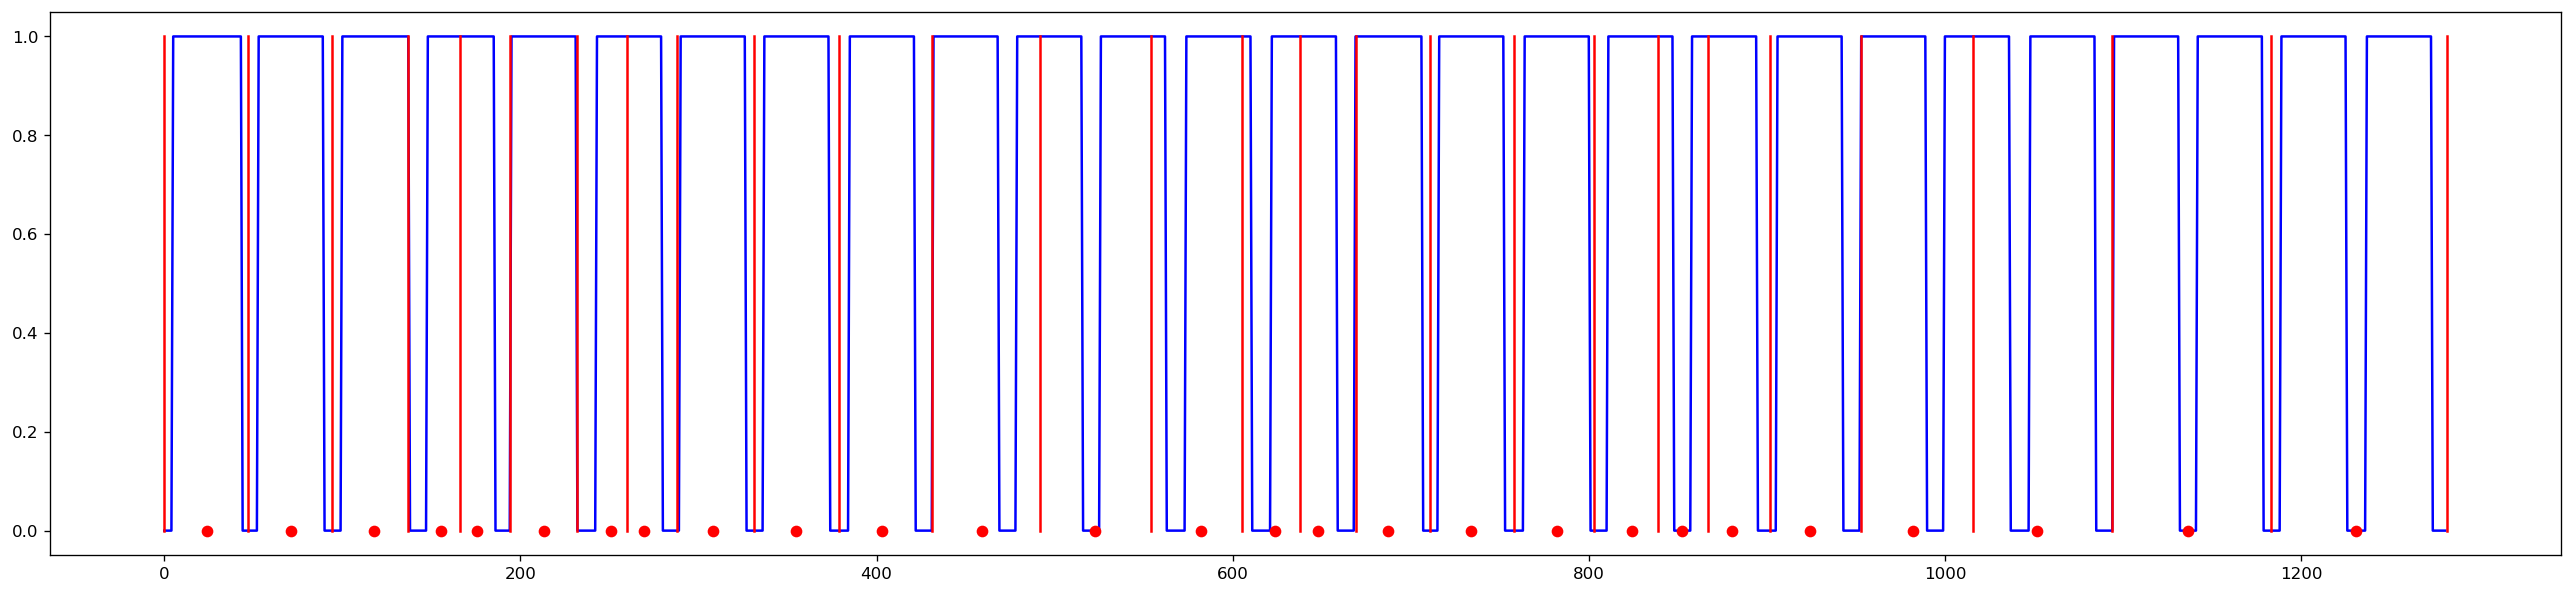

In [302]:
boundaries = np.hstack([0, (centers[:-1] + centers[1:])//2, len(data_thresh)]).astype(np.uint64)

new_centers = np.zeros_like(centers)
for i in range(len(boundaries)-1):
    if np.sum(data_thresh[boundaries[i]:boundaries[i+1]]) == 0:
        # print(i, centers[i], centers[i])
        new_centers[i] = centers[i]
    else:
        val = np.average(np.arange(boundaries[i], boundaries[i+1]), weights=data_thresh[boundaries[i]:boundaries[i+1]])
        # print(i, centers[i], val)
        new_centers[i] = val
        
centers = new_centers

plot_clusters(data_thresh, boundaries, centers)

In [304]:
def plot_clusters(data, boundaries, centers):
    plt.figure(figsize=(n_clusters,6))
    plt.plot(np.arange(len(data)), data, color='blue')
    for b in boundaries:
        plt.plot((b, b),(0, 1), color='red')
    plt.plot(centers, np.zeros(len(centers)), 'ro')
    
# plot_clusters(data_thresh, boundaries, centers)

In [231]:
i = 0
max_iter=5


In [452]:
183/8

22.875

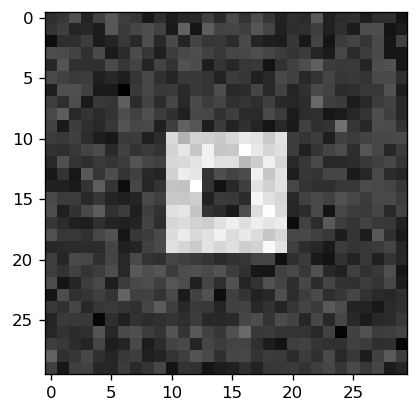

In [487]:
x = np.zeros((30,30), dtype=np.uint8)
# x[0:20, 0:5] = 200
x[10:20, 10:20]= 100
x[13:17, 13:17]=0
kernel1 = x[10:20, 10:20]

x = x + 10*np.random.randn(30,30)

plt.imshow(x, cmap='gray')

In [467]:
np.mean(x[5:7, 5:7])

100.6503201324075

(1600, 33) (30, 30)


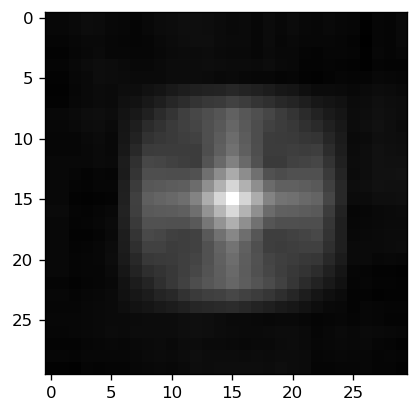

In [488]:

# kernel1[2:38, 2:38] = 0
kernel1 = kernel1/np.sum(kernel1)
pf = cv2.filter2D(src=x, ddepth=-1, kernel=kernel1)
plt.imshow(pf, cmap='gray')

print(p.shape, pf.shape)

In [486]:
np.unravel_index(pf.argmax(), pf.shape)

(0, 0)